In [1]:
import matplotlib.pyplot as plt
from torchvision import utils
from basic_fcn import *
from dataloader import *
from utils import *
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time
import math
import pickle
import numpy as np
from tqdm import tqdm
import gc

## Baseline / unet log file reading

In [6]:
f = open('unet.log', 'r')

train_losses = []
val_losses = []
train_losses_epoch = []
val_accs = []

lines = [x.rstrip('\n') for x in f.readlines()]

for line in lines[2392:]:
# for line in lines:
    temp = line.split()
    if temp[0].startswith('epoch'):
        if len(temp) > 17: # Validation
            val_losses.append(temp[9])
            val_accs.append(temp[12])
            train_losses_epoch.append(temp[6])
        elif len(temp) == 4:
            train_losses.append(temp[3])
            
train_losses = [float(x) for x in train_losses]
val_losses = [float(x.rstrip(',')) for x in val_losses]
train_losses_epoch = [float(x.rstrip(',')) for x in train_losses_epoch]
            
print(len(train_losses))
print(len(val_losses))
print(val_losses)
print(train_losses[:10])

2400
24
[0.7336795196204842, 0.6609543695778191, 0.619301930516066, 0.609351854838297, 0.6130530095385934, 0.5930472887204793, 0.595761002002362, 0.5909353724853721, 0.5974058505303845, 0.5932925040136554, 0.6083887688770979, 0.6341719140192705, 0.6245308568377694, 0.6179330439981586, 0.6572929179953958, 0.6528283116703262, 0.665774465856438, 0.7131816726958681, 0.6956105574876249, 0.7095506639180783, 0.7214373616044393, 0.7364769278172247, 0.7349859135236568, 0.7561723422147557]
[3.6744253635406494, 2.1727120876312256, 1.660318374633789, 1.981613039970398, 1.810918927192688, 1.5163345336914062, 1.6685017347335815, 1.617463231086731, 1.4555912017822266, 1.1161586046218872]


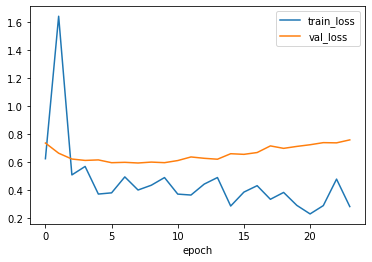

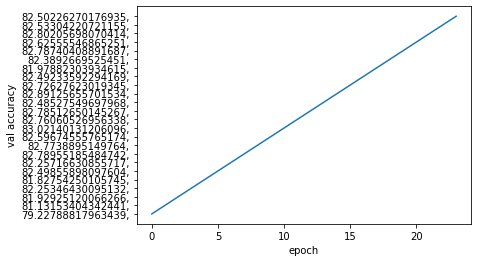

In [7]:
# plt.plot(train_losses)
# plt.xlabel('epoch')
# plt.ylabel('train loss')
# plt.show()

plt.plot(train_losses_epoch)
plt.xlabel('epoch')

plt.plot(val_losses)

plt.legend(['train_loss', 'val_loss'])
plt.show()

plt.plot(val_accs)
plt.xlabel('epoch')
plt.ylabel('val accuracy')
plt.show()

## Dice loss plots

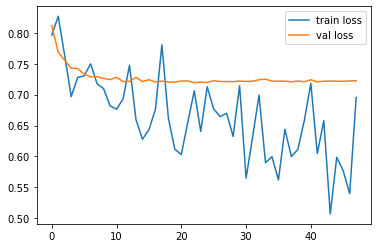

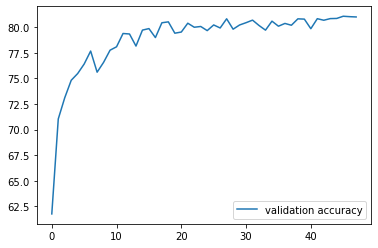

In [4]:
train_loss = [0.7965367436408997, 0.826980710029602, 0.7628846764564514, 0.6967681646347046, 0.7277342677116394, 0.7306920289993286, 0.7497867941856384, 0.7174460291862488, 0.7096636891365051, 0.6819741725921631, 0.6764377951622009, 0.6929275989532471, 0.7475759983062744, 0.6596727967262268, 0.6277400851249695, 0.6431928277015686, 0.6759940385818481, 0.7806349396705627, 0.6621986031532288, 0.6116136312484741, 0.6029437780380249, 0.6550886034965515, 0.7061471343040466, 0.6404536962509155, 0.7128106355667114, 0.6766709685325623, 0.6644774675369263, 0.6697002053260803, 0.6322616338729858, 0.7144671678543091, 0.5648606419563293, 0.630668044090271, 0.6991671323776245, 0.5898420810699463, 0.5994101166725159, 0.5618822574615479, 0.6439437866210938, 0.5996564030647278, 0.6112557053565979, 0.658360481262207, 0.7182813286781311, 0.6045059561729431, 0.6577626466751099, 0.5068142414093018, 0.5984817147254944, 0.576663613319397, 0.539673924446106, 0.6954683661460876]
val_loss = [0.811783674120903, 0.7687110018730163, 0.755375893831253, 0.7429456541538239, 0.7422992550134658, 0.7333996684551239, 0.7286552506685257, 0.7291188771724701, 0.7263140496015549, 0.7243128244876862, 0.728251809000969, 0.7211376477479935, 0.7213787537813187, 0.7280042332410812, 0.7211702864170074, 0.7242285401821137, 0.7205729682445526, 0.7219554905891419, 0.7204928052425384, 0.7201160645484924, 0.7219420217275619, 0.7222677992582321, 0.7192517967224121, 0.7204085302352905, 0.7196719441413879, 0.7225092703104019, 0.7213317536115647, 0.721235648393631, 0.7210649183988571, 0.7220167534351349, 0.7213965831995011, 0.7217222293615341, 0.7242166117429734, 0.7250262520313263, 0.7218988196849823, 0.7218339334726334, 0.7219126302003861, 0.7207730818986893, 0.7221211762428283, 0.7209468505382538, 0.7241167559623718, 0.7205979295969009, 0.7217451583147049, 0.7220574986934661, 0.7217951496839523, 0.7216693085432052, 0.7221518537998199, 0.7225340045690537]
val_accs = [61.76764974594116, 71.03232469558716, 73.10295543670654, 74.80540437698365, 75.46460418701172, 76.39201955795288, 77.65673999786377, 75.59538831710816, 76.55745286941529, 77.74182319641113, 78.07309284210206, 79.3691032409668, 79.32235507965088, 78.14389715194702, 79.70104846954345, 79.84786548614503, 78.97198057174683, 80.4168306350708, 80.50475797653198, 79.39868850708008, 79.51165838241577, 80.37368392944336, 79.98036212921143, 80.05415382385254, 79.6509874343872, 80.20441045761109, 79.90816717147827, 80.80340356826783, 79.79091100692749, 80.20086030960083, 80.42465839385986, 80.67374744415284, 80.15119943618774, 79.69698104858398, 80.57367172241212, 80.08134336471558, 80.35107135772705, 80.17474632263183, 80.7991602897644, 80.77288455963135, 79.83789501190185, 80.81353378295898, 80.66271705627442, 80.82243194580079, 80.83880348205567, 81.0530119895935, 81.01161441802978, 80.98348169326782]

plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train loss', 'val loss'])
plt.show()

plt.plot(val_accs)
plt.legend(['validation accuracy'])
plt.show()

In [2]:
def val(model, val_loader, criterion, use_gpu):
    
    # set to evaluation mode 
    model.eval()

    softmax = nn.Softmax(dim = 1)
    
    loss = []
    pred = []
    acc = []
    
    IOU_init = False
    if use_gpu:
        device = torch.device("cuda:0")
        
        #model.to(device)
        
#     for iter, (X, tar, Y) in tqdm(enumerate(val_loader)):
    count = 0
    for iter, (X, tar, Y) in enumerate(val_loader):
        
        if not IOU_init:
            IOU_init = True
            IOU = np.zeros((1,19))
            
        if use_gpu:
            inputs = X.to(device)
            labels = Y.to(device)
            
        else:
            inputs, labels = X, Y

            
        with torch.no_grad():   
            outputs = model(inputs)    
            loss.append(criterion(outputs, labels.long()).item())
            prediction = softmax(outputs) 
#             print('pred shape: ', prediction.shape)
#             print('labels shape: ', labels.shape)
#             acc.append(pixel_acc(prediction, labels).item())
            acc.append(pixel_acc(prediction, labels))
            IOU = IOU + np.array(iou(prediction, labels))
            
        if iter % 100 == 0:
            print('iter: ', iter)
#         count += 1
#         if count == 7:
#             break
        
#     print(iter)
    acc = sum(acc)/len(acc)
    avg_loss = sum(loss)/len(loss) 
    IOU = IOU/iter  
    
    return avg_loss, acc, IOU      

In [3]:
train_dataset = CityScapesDataset(csv_file='train.csv')
val_dataset = CityScapesDataset(csv_file='val.csv')
train_loader = DataLoader(dataset=train_dataset,
                      batch_size=2,
                      num_workers=4,
                      shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                      batch_size=2,
                      num_workers=4,
                      shuffle=True)

criterion = torch.nn.CrossEntropyLoss()
use_gpu = torch.cuda.is_available()
print('use gpu: ', use_gpu)

val_losses = []
val_accs = []
val_ious = []

use gpu:  True


In [4]:
for epoch in range(27):
    fcn_model = torch.load('weights_baseline/epoch-{}'.format(epoch))
    
    val_loss, val_acc, val_iou = val(fcn_model, val_loader, criterion, use_gpu)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_ious.append(val_iou)
    print('epoch {} done'.format(epoch))
#     print('iou shape: ', val_iou.shape)
#     print(val_loss, val_acc, val_iou)

(19,)
iter:  0
(19,)
(19,)
(19,)
(19,)
(19,)
(19,)
(19,)
(19,)
(19,)
(19,)
(19,)
(19,)
(19,)
(19,)
(19,)
(19,)


KeyboardInterrupt: 

In [9]:
to_save = {}
to_save['val_accs'] = val_accs
to_save['val_losses'] = val_losses
to_save['val_ious'] = val_ious

pickle.dump(to_save, open('val_stats.pkl', 'wb'))

[55.49338932037354, 68.51301870346069, 71.15557928085327, 71.82049713134765, 74.96293067932129, 74.91591968536378, 76.26115865707398, 78.49598350524903, 78.62611036300659, 79.8488205909729, 81.01106271743774, 81.40178747177124, 81.81879453659057, 81.67829895019531, 82.27137107849121, 82.3140097618103, 82.10966081619263, 82.0537356376648, 83.03013830184936, 82.6362193107605, 83.31261348724365, 82.46640911102295, 83.32848243713379, 82.78832521438599, 82.87316207885742, 83.36629161834716, 82.85327529907227]


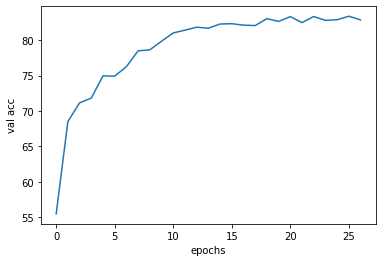

[0.6430594237925172, 0.7084697616079937, 0.7392475181933545, 0.7238359939581904, 0.7651136452612195, 0.7664608567458283, 0.7735230518291215, 0.8073639512741696, 0.8177111345233959, 0.8179471797649281, 0.8314621017566683, 0.8317849506515502, 0.8418329913565485, 0.842088452726063, 0.8467905849139191, 0.8468059356681789, 0.846299545617504, 0.8489332903693986, 0.8563744852633208, 0.8445446620243535, 0.8585683381217983, 0.8500359560608174, 0.8533916229612463, 0.8562016318635052, 0.8429559337477149, 0.8588583036975754, 0.8587757121586838]
Overall average iou:  0.8140161857744284


In [14]:
v = pickle.load(open('val_stats.pkl', 'rb'))
val_accs = v['val_accs']
val_ious = v['val_ious']

print(val_accs)
plt.plot(val_accs)
plt.xlabel('epochs')
plt.ylabel('val acc')
plt.show()

max_class_ious = []
for iou in val_ious:
#     print(iou.shape)
    
    iou = iou[~np.isnan(iou)]
    
    max_class_ious.append(np.max(iou))
    
print(max_class_ious)
print('Overall average iou: ', np.average(np.array(max_class_ious)))